---
title: Exploratory Data Analysis  
exports:
  - format: pdf
    output: pdf_builds/eda.pdf
---

In this notebook we utilized the NASA earthaccess python library to get velocity maps for the South Rimo Glacier in Karakoram mountain range in Pakistan, the Sít’ Kusá Glacier in Alaska and the Medvezhiy Glacier in Tajikistan. We loaded the data in Xarray Datasets to conduct prelimanary data analysis including coordinate-based velocity magnitude plots for each glacier and a summary statistics table.

In [1]:
import glob
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import os
import glaciers.glaciers as gl #our custom glaciers library!

We used earthacess a Python library to search for and download or stream NASA Earth science data. 

In [2]:
#import earthaccess
#earthaccess.login()

This requires a free account and a username and password each time the data is accessed but we've already downloaded all data necessary for this project into our repo's `data` folder so that isn't requried for you to run our notebooks :) If you wish to reproduce this project feel free to uncomment these lines to download the data for yourself. We've included code for downloading the data for other glaciers as well if that's what your're interested in.

In [3]:
#granules = earthaccess.search_data(
 #   short_name="NSIDC-0801",
  #  doi='10.5067/VHFVXHZHOO6P'
#)

#MZ_results = granules[0]
#SR_results = granules[1:3]
#SK_results = granules[3]
#AV_results = granules[4]
#LO_results = granules[5]

where:  
MZ = Medvezhiy Glacier in Tajikistan  
**SR = South Rimo Glacier in Karakoram(Pakistan)**  
SK = Sít' Kusá Glacier in Alaska  
AV = Aavatsmarkbreen Glacier in Norway  
LO = Nàłùdäy/Lowell Glacier in Canada

In [4]:
#os.makedirs("data/Karakoram", exist_ok=True)
#os.makedirs("data/Other_Glaciers/Tajikistan", exist_ok=True)
#os.makedirs("data/Other_Glaciers/Alaska", exist_ok=True)

#SR_files=earthaccess.download(SR_results, local_path='data/Karakoram')
#MZ_files=earthaccess.download(MZ_results, local_path='data/Other_Glaciers/Tajikistan')
#SK_files=earthaccess.download(SK_results, local_path='data/Other_Glaciers/Alaska')

We're focusing on the South Rimo Glacier in the Karakoram mountain range in Pakistan and comparing it to a couple non-Karakoram glaciers: the Sít’ Kusá Glacier in Alaska and the Medvezhiy Glacier in Tajikistan. We've downloaded and saved each of these three datasets into their respective folders. 

In [5]:
K_geotiffs_ds = gl.geotiff_to_ds("data/Karakoram/*_vm_*.tif")
A_geotiffs_ds = gl.geotiff_to_ds("data/Other_Glaciers/Alaska/*_vm_*.tif")
T_geotiffs_ds = gl.geotiff_to_ds("data/Other_Glaciers/Tajikistan/*_vm_*.tif")

Now that we've got our data into an Xarray Dataset we will now try to plot some of our glacier velocity measurements(x-direction velocity, y-direction velocity, and overall velocity magnitude). We'll plot the first and last image dates for each velocity type for the Karakoram glacier, followed by just the velocity magnitudes for the remaining glaciers since that's our primary variable of interest. This will allows us to see the overall geography for each glacier, the time interval over which we have data for it, and to make sure everything is in order with our variables.

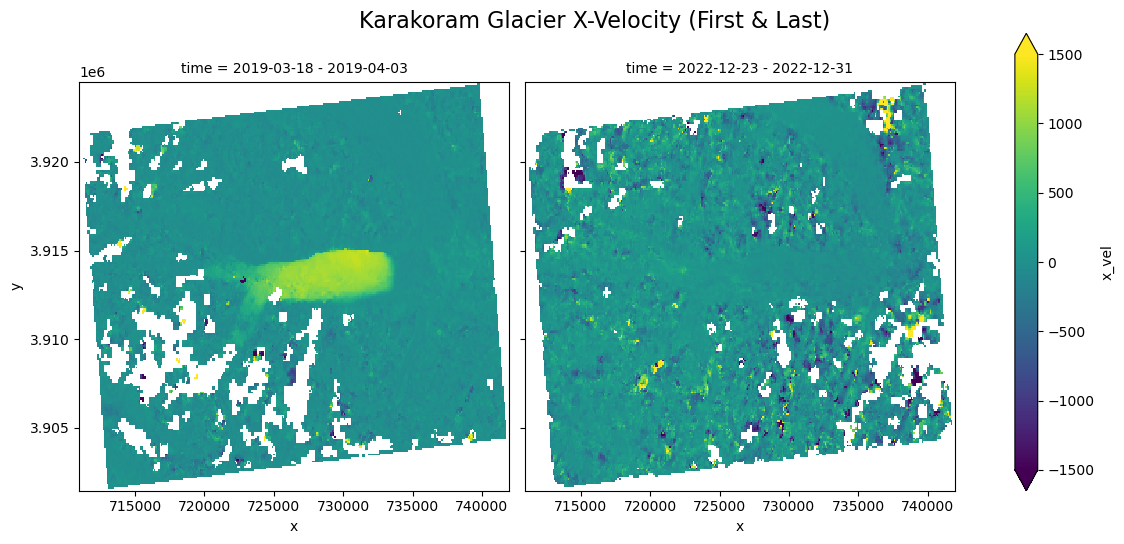

In [6]:
K_subset = K_geotiffs_ds.isel(time=[0, -1])

K_subset.x_vel.plot(col="time", col_wrap=2,figsize=(12, 5.5), vmin=-1500, vmax=1500) 
plt.suptitle("Karakoram Glacier X-Velocity (First & Last)", fontsize=16)
plt.subplots_adjust(top=0.85, right = 0.8)
plt.show()

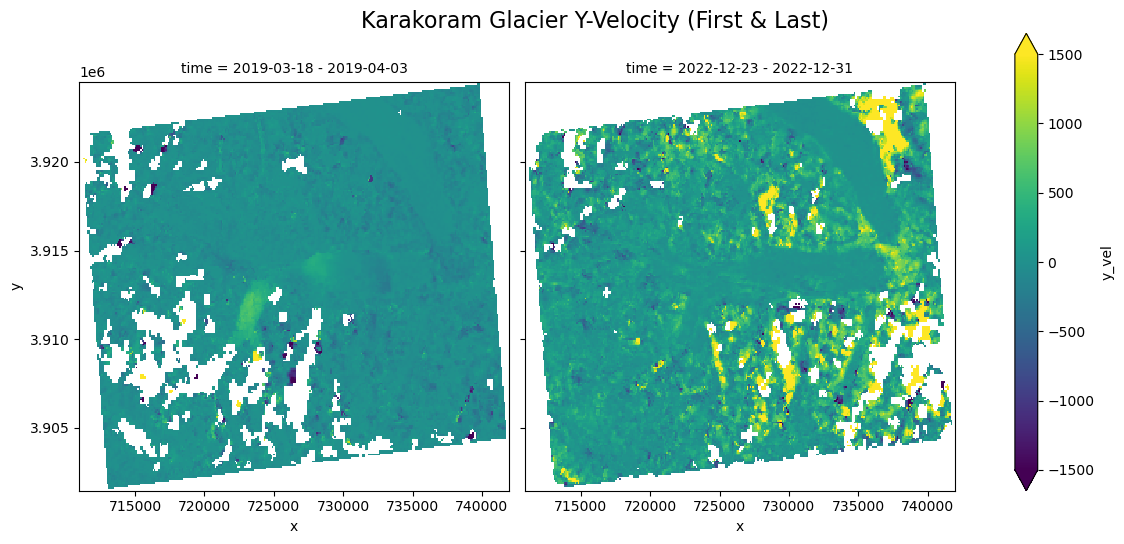

In [7]:
K_subset.y_vel.plot(col="time", col_wrap=2,figsize=(12, 5.5), vmin=-1500, vmax=1500) 
plt.suptitle("Karakoram Glacier Y-Velocity (First & Last)", fontsize=16)
plt.subplots_adjust(top=0.85, right = 0.8)
plt.show()

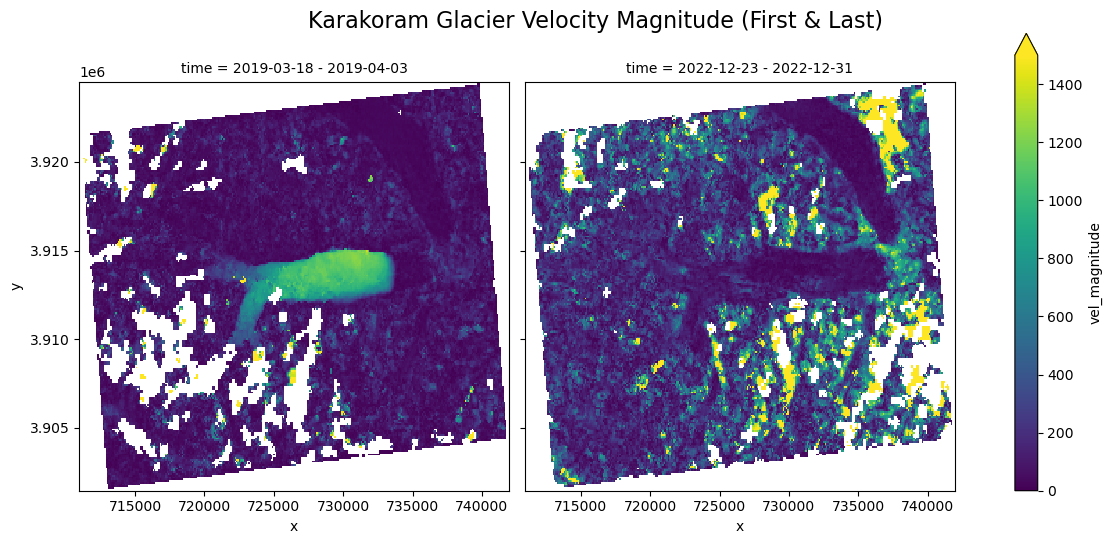

In [8]:
K_subset.vel_magnitude.plot(col="time", col_wrap=2,figsize=(12, 5.5), vmax=1500) 
plt.suptitle("Karakoram Glacier Velocity Magnitude (First & Last)", fontsize=16)
plt.subplots_adjust(top=0.85, right = 0.8)
plt.show()

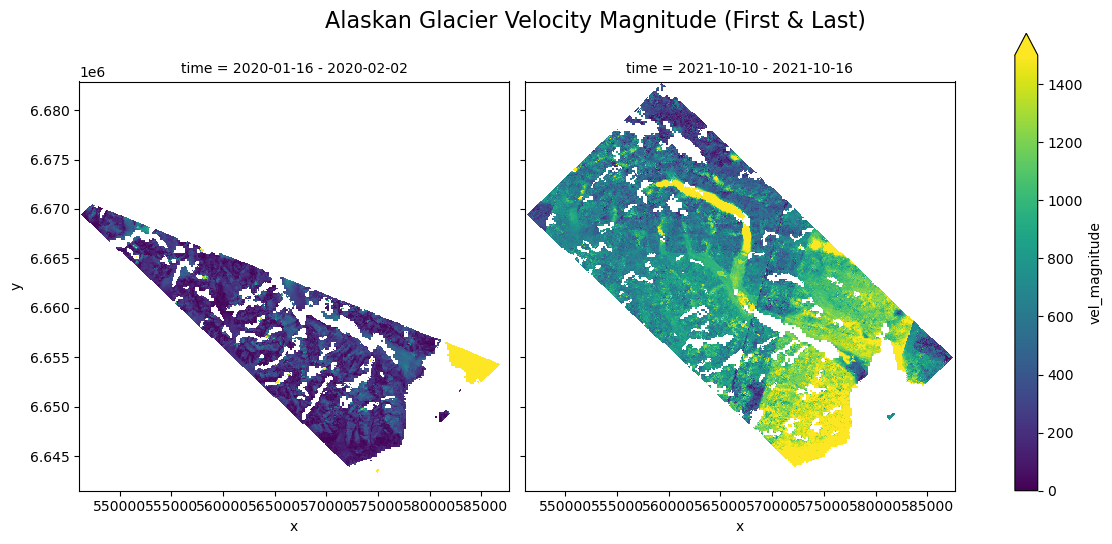

In [9]:
A_subset = A_geotiffs_ds.isel(time=[0, -1])

A_subset.vel_magnitude.plot(col="time", col_wrap=2,figsize=(12, 5.5), vmax=1500) 
plt.suptitle("Alaskan Glacier Velocity Magnitude (First & Last)", fontsize=16)
plt.subplots_adjust(top=0.85, right = 0.8)
plt.show()

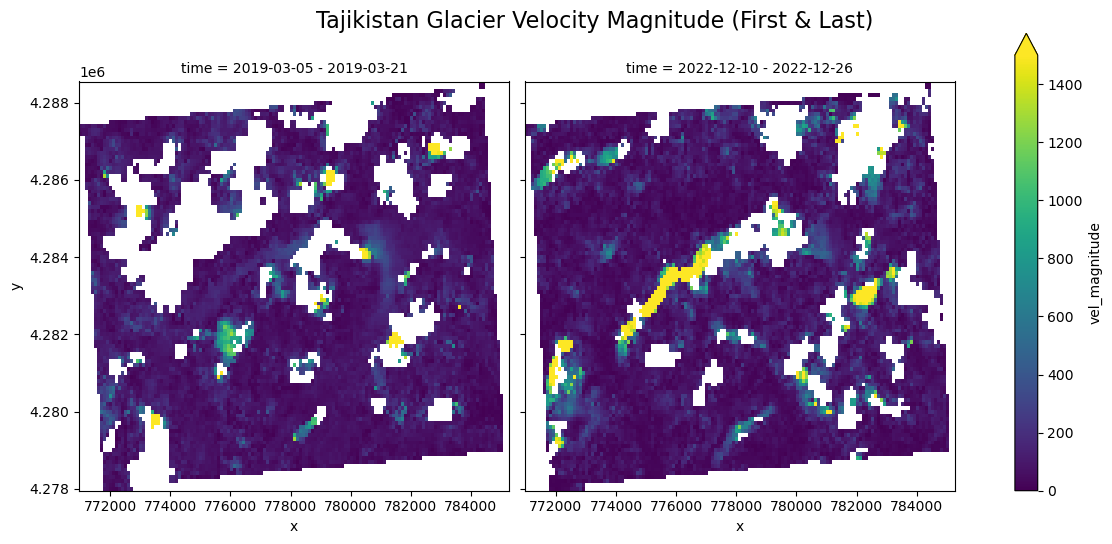

In [10]:
T_subset = T_geotiffs_ds.isel(time=[0, -1])

T_subset.vel_magnitude.plot(col="time", col_wrap=2,figsize=(12, 5.5), vmax=1500) 
plt.suptitle("Tajikistan Glacier Velocity Magnitude (First & Last)", fontsize=16)
plt.subplots_adjust(top=0.85, right = 0.8)
plt.show()

In [11]:
geotiffs_ds = [K_geotiffs_ds, A_geotiffs_ds, T_geotiffs_ds]
ds_names = ["Karakoram", "Alaska", "Tajikistan"]

for name, ds in zip(ds_names, geotiffs_ds):
    non_nan_count = ds['vel_magnitude'].count().values
    total_count = ds['vel_magnitude'].size
    percent = non_nan_count / total_count * 100
    print(f"{name} Glacier: {non_nan_count} / {total_count} non-NaN values = {percent:.2f}%")

Karakoram Glacier: 11688945 / 22055880 non-NaN values = 53.00%
Alaska Glacier: 2093729 / 8266752 non-NaN values = 25.33%
Tajikistan Glacier: 1021933 / 1803802 non-NaN values = 56.65%


So we have two potential issues visible from the plots above. Firstly, the date ranges for the three glaciers' datasets differ and secondly, there are inconsistent blank spaces/NaN values as shown in the ouput above as well. The first issue will be addressed by trimming the larger datasets to match the smallest(Alaskan glacier) and the second can more or less be ignored since our analysis will only use the coordinates for which we have data values instead of the entire region.

In [12]:
rows = []

for name, ds in zip(ds_names, geotiffs_ds):
    for var in ds.data_vars:
        rows.append({
            "Glacier": name,
            "Variable": var,
            "Min": float(ds[var].min().values),
            "Max": float(ds[var].max().values),
            "Mean": float(ds[var].mean().values),
            "Median": float(ds[var].median().values)
        })

# Convert to DataFrame
full_summary_stats_df = pd.DataFrame(rows)

# Display table
print("Overall Velocities' Summary Statistics")
pd.options.display.float_format = "{:.2f}".format
full_summary_stats_df

Overall Velocities' Summary Statistics


,Glacier,Variable,Min,Max,Mean,Median
0,Karakoram,x_vel,-13131.75,11872.68,23.94,5.35
1,Karakoram,y_vel,-12108.26,11167.79,-0.79,0.00
2,Karakoram,vel_magnitude,0.00,17070.92,413.69,252.49
3,Alaska,x_vel,-7821.43,9634.99,4.77,-17.11
4,Alaska,y_vel,-8397.73,7821.43,-71.23,-24.44
5,Alaska,vel_magnitude,0.00,11332.05,696.03,371.54
6,Tajikistan,x_vel,-5261.92,5127.47,-11.33,-3.80
7,Tajikistan,y_vel,-5127.47,6035.12,9.54,4.28
8,Tajikistan,vel_magnitude,0.00,7258.89,159.14,86.85


From our EDA we can see that we were able to load our data into the format we need for our analysis (Xarray Datasets). We are able to plot each of the velocity variables for each of the three glaciers. Our summary statistics and explanatory plots show that there is great variation in glacier velocity in three measureable ways. Firstly, over time for a given glacier; secondly, over the geographic span of a given glacier's dataset; and finally, from one glacier to another. The last one being the one we are most interested in for this project. We also found that before we proceed with any analysis we must trim our Karakoram and Tajikistan glacier datasets to match the timeframe of the Alaskan glacier dataset(2020-01-16 to 2021-10-16) for more even comparisons.

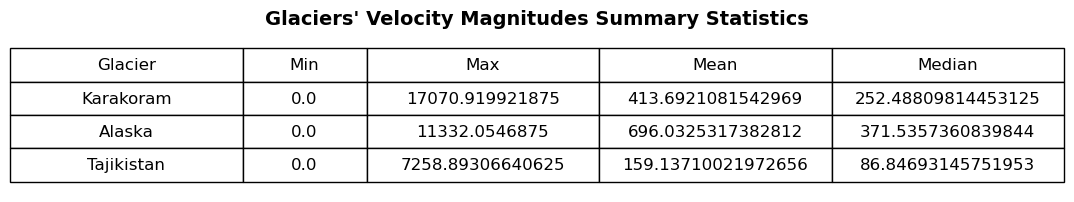

In [13]:
#creating/saving figure for main notebook comparisons
summary_stats_df = full_summary_stats_df.iloc[[2, 5, 8]].drop(columns=['Variable'])

fig, ax = plt.subplots(figsize=(4, 2))
ax.axis('off')
table = ax.table(cellText=summary_stats_df.values, colLabels=summary_stats_df.columns, loc='center', cellLoc='center')
table.set_fontsize(13)
table.scale(1, 2)
col_widths = [0.75, 0.4, 0.75, 0.75, 0.75]
for (i, j), cell in table.get_celld().items():
    cell.set_width(col_widths[j])
ax.set_title("Glaciers' Velocity Magnitudes Summary Statistics", fontsize=14, fontweight='bold', pad=10)

plt.savefig("figures/glaciers'_velocity_comparisons_table.png", dpi=300)